# Estimate modeled snowline altitudes and ELAs

In [5]:
import os
from scipy import optimize
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import median_abs_deviation as MAD
from tqdm.auto import tqdm
import glob
import geopandas as gpd

In [ ]:
# Path for inputs and outputs
scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'

# Grab modeled SMB file names
modeled_path = os.path.join(scm_path, 'Rounce_et_al_2023', 'binned')

# AOIs
aois_fn = os.path.join(scm_path, 'analysis', 'all_aois.shp')


## Modeled snowline altitudes

In [3]:
# Functions for linearly extrapolating the ELA when modeled SMB < 0 everywhere
def linear_fit(x, m, b):
    return m*x + b
    
def extrapolate_ela_linear(X,y, Iend=8):
    # optimize the linear fit
    p, e = optimize.curve_fit(linear_fit, X[0:Iend+1], y[0:Iend+1])
    # extrapolate where y=0
    ela = linear_fit(0, *p)
    return ela

In [16]:
# -----Monthly snowline altitudes
mod_slas_monthly_fn = os.path.join(scm_path, 'analysis', 'monthly_SLAs_modeled.csv')
if os.path.exists(mod_slas_monthly_fn):
    mod_slas_monthly = pd.read_csv(mod_slas_monthly_fn)
    mod_slas_monthly['Date'] = pd.DatetimeIndex(mod_slas_monthly['Date'])
    print('Modeled monthly SLAs loaded from file.')
else:
    
    # load binned model data
    bin_fns = sorted(glob.glob(os.path.join(modeled_path, '*.nc')))

    # load glacier boundaries
    aois = gpd.read_file(aois_fn)
    
    # remove binned file names for sites without snow cover observations
    aoi_ids = [x[7:] for x in sorted(aois['RGIId'].drop_duplicates().values)]
    bin_fns = [x for x in bin_fns if os.path.basename(x)[0:7] in aoi_ids]

    # initialize dataframe for results
    mod_slas_monthly = pd.DataFrame()

    # iterate over binned file names
    i=0
    for bin_fn in tqdm(bin_fns):
        # open binned data
        bin = xr.open_dataset(bin_fn)
        rgi_id = bin.RGIId.data[0] # grab RGI ID

        # grab data variables
        h = bin.bin_surface_h_initial.data[0] # surface elevation [m]
        b_sum = np.zeros((len(bin.time.data), len(h))) # cumulative SMB
        times = [np.datetime64(x) for x in bin.time.data] # datetimes
        months = list(pd.DatetimeIndex(times).month) # months of each datetime
        elas = np.zeros(len(times)) # initialize transient ELAs

        # iterate over each time period
        for j, time in enumerate(times):
            # subset binned data to time
            bin_time = bin.isel(time=j)
            # grab the SMB 
            b_sum[j,:] = bin_time.bin_massbalclim_monthly.data[0]
            # add the previous SMB (restart the count in October)
            if months[j] != 10: 
                b_sum[j,:] += b_sum[j-1,:]
            # If all SMB > 0, ELA = minimum elevation
            if all(b_sum[j,:] > 0):
                elas[j] = np.min(h)
            # If SMB is > 0 and < 0 in some places, linearly interpolate ELA
            elif any(b_sum[j,:] < 0) & any(b_sum[j,:] > 0):
                elas[j] = np.interp(0, np.flip(b_sum[j,:]), np.flip(h))
            # If SMB < 0 everywhere, fit a piecewise linear fit and extrapolate for SMB=0
            elif all(b_sum[j,:] < 0):
                X, y = b_sum[j,:], h
                elas[j] = extrapolate_ela_linear(X, y, Iend=5)
            else:
                print('issue')

        # compile in dataframe
        df = pd.DataFrame({'Date': times,
                           'ELA_m': elas})
        
        # Because each SMB value represents the total SMB for each month, add 1 month to the dates
        df['Date'] = df['Date'] + pd.DateOffset(months=1)
        df['RGIId'] = rgi_id

        mod_slas_monthly = pd.concat([mod_slas_monthly, df])
            
        i+=1

    # Rearrange columns
    mod_slas_monthly = mod_slas_monthly[['RGIId', 'Date', 'ELA_m', 
                                         'cumulative_positive_degree_days', 
                                         'cumulative_snowfall_sum']]
    # save to file
    mod_slas_monthly.to_csv(mod_slas_monthly_fn, index=False)
    print('Modeled monthly SLAs saved to file:', mod_slas_monthly_fn)

mod_slas_monthly.reset_index(drop=True, inplace=True)
mod_slas_monthly

Modeled monthly SLAs loaded from file.


,RGIId,Date,ELA_m,cumulative_positive_degree_days,cumulative_snowfall_sum
0,RGI60-01.00032,2012-10-01,2139.146867,0.000000,0.000102
1,RGI60-01.00032,2012-11-01,1430.317692,0.000000,0.057780
2,RGI60-01.00032,2012-12-01,1430.317692,0.000000,0.072304
3,RGI60-01.00032,2013-01-01,1430.317692,0.000000,0.093104
4,RGI60-01.00032,2013-02-01,1430.317692,0.000000,0.152280
...,...,...,...,...,...
24795,RGI60-02.18778,2022-09-01,1747.136444,999.441108,1.420873
24796,RGI60-02.18778,2022-10-01,2032.139668,1293.003237,0.000000
24797,RGI60-02.18778,2022-11-01,2172.170680,1484.923959,0.110614
24798,RGI60-02.18778,2022-12-01,1949.359008,1484.923959,0.304903


## Modeled ELAs

In [ ]:
mod_elas_annual_fn = os.path.join(scm_path, 'analysis', 'annual_ELAs_modeled.csv')
if os.path.exists(mod_elas_annual_fn):
    mod_elas_annual = pd.read_csv(mod_elas_annual_fn)
    mod_elas_annual['Date'] = pd.to_datetime(mod_elas_annual['Date'])
    print('Modeled annual ELAs loaded from file.')
else:
    # Add Year column
    mod_slas_monthly['Year'] = pd.DatetimeIndex(mod_slas_monthly['Date']).year
    # Identify the row of maximum ELA for each site and each year
    Imax = mod_slas_monthly.groupby(by=['RGIId', 'Year'])['ELA_m'].idxmax().values
    mod_elas_annual = mod_slas_monthly.iloc[Imax].reset_index(drop=True)
    # Reorder columns
    mod_elas_monthly = mod_slas_monthly[['RGIId', 'Date', 'Year', 'ELA_m', 
                                         'cumulative_positive_degree_days',
                                         'cumulative_snowfall_sum']]
    # Save to file
    mod_elas_annual.to_csv(mod_elas_annual_fn, index=False)
    print('Modeled annual ELAs saved to file:', mod_elas_annual_fn)
    
mod_elas_annual

Modeled annual ELAs loaded from file.


,RGIId,Date,ELA_m,cumulative_positive_degree_days,cumulative_snowfall_sum,Year
0,RGI60-01.00032,2012-10-01,2139.146867,0.000000,1.017484e-04,2012
1,RGI60-01.00032,2013-08-01,2614.503745,325.809940,3.775567e-01,2013
2,RGI60-01.00032,2014-09-01,2126.715067,187.425379,5.039817e-01,2014
3,RGI60-01.00032,2015-08-01,2266.612695,258.587416,3.120194e-01,2015
4,RGI60-01.00032,2016-09-01,2431.285897,327.698403,3.270600e-01,2016
...,...,...,...,...,...,...
2395,RGI60-02.18778,2019-10-01,2187.026191,1203.387599,1.063343e-05,2019
2396,RGI60-02.18778,2020-10-01,2025.103496,1211.252127,0.000000e+00,2020
2397,RGI60-02.18778,2021-10-01,2135.926640,1388.275927,1.013252e-07,2021
2398,RGI60-02.18778,2022-11-01,2172.170680,1484.923959,1.106143e-01,2022


## Remotely-sensed snowline altitudes (monthly)

In [95]:
obs_slas_monthly_fn = os.path.join(scm_path, 'analysis', 'monthly_SLAs_observed.csv')
if not os.path.exists(obs_slas_monthly_fn):
    # load AOIs
    aois = gpd.read_file(aois_fn)

    # iterate over sites
    obs_slas_monthly = pd.DataFrame()
    for rgi_id in tqdm(sorted(aois['RGIId'].drop_duplicates().values)):
        scs_fn = os.path.join(scm_path, 'study-sites', rgi_id, f'{rgi_id}_snow_cover_stats.csv')
        scs = pd.read_csv(scs_fn)
        scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
        scs['Year'] = scs['datetime'].dt.year
        scs['Month'] = scs['datetime'].dt.month
        scs['Day'] = scs['datetime'].dt.day
        # Filter data to within one week of the first of each month
        scs_filtered = scs[(scs['Day'] >= 25) | (scs['Day'] <= 7)]
        # Function to identify the row closest to the first of each month
        Imonths = []
        for year, month in scs_filtered[['Year', 'Month']].drop_duplicates().values:
            first_of_month = pd.Timestamp(year=year, month=month, day=1)
            # identify closest observation to this date
            scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
            Imonths.append(scs_filtered['diff'].idxmin())
        scs_monthly = scs.iloc[Imonths]

        # concatenate to full dataframe
        obs_slas_monthly = pd.concat([obs_slas_monthly, scs_monthly])

    # add a "Date" column that is first of month
    obs_slas_monthly['Date'] = pd.to_datetime(obs_slas_monthly[['Year', 'Month']].assign(Day=1))

    # select relevant columns
    obs_slas_monthly = obs_slas_monthly[['RGIId', 'Date', 'ELA_from_AAR_m']]
    obs_slas_monthly.reset_index(drop=True, inplace=True)

    # save to file
    obs_slas_monthly.to_csv(obs_slas_monthly_fn, index=False)
    print('Remotely-sensed monthly SLAs saved to file:', obs_slas_monthly_fn)

else:  
    obs_slas_monthly = pd.read_csv(obs_slas_monthly_fn)
    print('Remotely-sensed monthly SLAs loaded from file.')

obs_slas_monthly


  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1811461067.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1811461067.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1811461067.py:22: 

Remotely-sensed monthly SLAs saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/monthly_SLAs_observed.csv


,RGIId,Date,ELA_from_AAR_m
0,RGI60-01.00032,2013-05-01,1447.7217
1,RGI60-01.00032,2013-10-01,1438.1063
2,RGI60-01.00032,2014-06-01,1519.7489
3,RGI60-01.00032,2014-09-01,1830.5894
4,RGI60-01.00032,2016-05-01,1400.9528
...,...,...,...
8621,RGI60-02.18778,2023-06-01,1757.2461
8622,RGI60-02.18778,2023-07-01,1758.1294
8623,RGI60-02.18778,2023-07-01,1889.8429
8624,RGI60-02.18778,2023-09-01,2015.7803


## Remotely-sensed ELAs (from monthly time series)

In [106]:
obs_elas_annual_fn = os.path.join(scm_path, 'analysis', 'annual_ELAs_observed.csv')
if not os.path.exists(obs_elas_annual_fn):
    # iterate over sites
    obs_elas_annual = pd.DataFrame()
    for rgi_id in tqdm(obs_slas_monthly['RGIId'].drop_duplicates().values):
        obs_slas_monthly_site = obs_slas_monthly.loc[obs_slas_monthly['RGIId']==rgi_id].reset_index(drop=True)
        # identify maximum annual SLA
        imax = obs_slas_monthly_site.groupby(obs_slas_monthly_site['Date'].dt.year)['ELA_from_AAR_m'].idxmax().values
        df = obs_slas_monthly_site.iloc[imax]
        # concatenate to full dataframe
        obs_elas_annual = pd.concat([obs_elas_annual, df])
    obs_elas_annual.reset_index(drop=True, inplace=True)

    # save to file
    obs_elas_annual.to_csv(obs_elas_annual_fn, index=False)
    print('Remotely-sensed ELAs saved to file:', obs_elas_annual_fn)

else:
    obs_elas_annual = pd.read_csv(obs_elas_annual_fn)
    print('Remotely-sensed ELAs loaded from file.')

obs_elas_annual

  0%|          | 0/204 [00:00<?, ?it/s]

Remotely-sensed ELAs saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/annual_ELAs_observed.csv


,RGIId,Date,ELA_from_AAR_m
0,RGI60-01.00032,2013-05-01,1447.7217
1,RGI60-01.00032,2014-09-01,1830.5894
2,RGI60-01.00032,2016-08-01,2297.3313
3,RGI60-01.00032,2017-08-01,2706.3940
4,RGI60-01.00032,2018-07-01,2464.6482
...,...,...,...
2099,RGI60-02.18778,2019-08-01,1921.5100
2100,RGI60-02.18778,2020-09-01,1852.0300
2101,RGI60-02.18778,2021-09-01,1845.7200
2102,RGI60-02.18778,2022-09-01,2012.9600


## Difference modeled to remotely-sensed snowlines

### Calculate minimum remotely-sensed snowline altitudes for standardizing elevations

In [17]:
# Define output file name
min_obs_sla_fn = os.path.join(scm_path, 'analysis', 'minimum_remotely-sensed_snowline_altitudes.csv')
if not os.path.exists(min_obs_sla_fn):
    # load AOIs
    aois = gpd.read_file(aois_fn)
    min_obs_sla = pd.DataFrame()
    # Iterate over sites
    for rgi_id in tqdm(aois['RGIId'].drop_duplicates().values):
        # Load snowlines
        scs_fn = os.path.join(scm_path, 'study-sites', rgi_id, f'{rgi_id}_snow_cover_stats.csv')
        scs = pd.read_csv(scs_fn)
        # Remove any wonky values
        scs.loc[np.abs(scs['ELA_from_AAR_m']) > 1e10] = np.nan
        # Get minimum snowline altitude
        min_sla = scs['ELA_from_AAR_m'].min()
        # Add to dataframe
        df = pd.DataFrame({'RGIId': [rgi_id], 'SLA_min_m': [min_sla]})
        min_obs_sla = pd.concat([min_obs_sla, df], axis=0)

    # Save to file
    min_obs_sla.reset_index(drop=True, inplace=True)
    min_obs_sla.to_csv(min_obs_sla_fn, index=False)
    print('Minimum snowline altitudes saved to file:', min_obs_sla_fn)
    
else:
    min_obs_sla = pd.read_csv(min_obs_sla_fn)
    print('Minimum snowline altitudes loaded.')

min_obs_sla

  0%|          | 0/200 [00:00<?, ?it/s]

Minimum snowline altitudes saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/minimum_remotely-sensed_snowline_altitudes.csv


,RGIId,SLA_min_m
0,RGI60-01.00032,1400.952800
1,RGI60-01.00033,1107.104700
2,RGI60-01.00037,-425.248720
3,RGI60-01.00038,895.128970
4,RGI60-01.00046,54.785244
...,...,...
195,RGI60-02.17736,1216.000000
196,RGI60-02.17738,1180.000000
197,RGI60-02.17739,1577.000000
198,RGI60-02.17741,1405.000000


### Calculate monthly snowline altitudes

Merged monthly SLAs loaded.


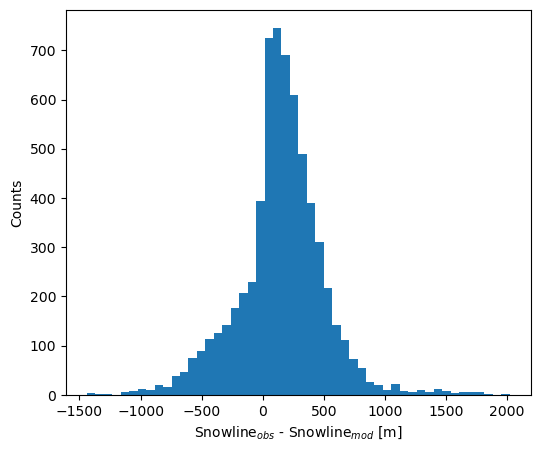


Difference stats:
Mean diff = 149.8357426899993 m
Std. diff = 352.9497397565886 m
Median diff = 155.60148823529403 m
MAD diff = 164.537046611071 m


In [19]:
# Define output file
slas_monthly_merged_fn = os.path.join(scm_path, 'analysis', 'monthly_SLAs_modeled_observed_merged.csv')
if not os.path.exists(slas_monthly_merged_fn):

    # Merge modeled and remotely-sensed ELAs
    slas_monthly_merged = mod_slas_monthly[['RGIId', 'Date', 'ELA_m']].merge(obs_slas_monthly[['RGIId', 'Date', 'ELA_from_AAR_m']], 
                                                                             on=['RGIId', 'Date'])
    # Remove 2023 values (no modeled data in 2023)
    slas_monthly_merged = slas_monthly_merged.loc[pd.DatetimeIndex(slas_monthly_merged['Date']).year < 2023]
    
    # Remove observations outside May - September
    slas_monthly_merged = slas_monthly_merged.loc[(pd.DatetimeIndex(slas_monthly_merged['Date']).month >=5) 
                                                & (pd.DatetimeIndex(slas_monthly_merged['Date']).month <=9)]
    
    # Rename columns
    slas_monthly_merged.rename(columns={'ELA_m': 'ELA_mod_m', 'ELA_from_AAR_m': 'ELA_obs_m'}, inplace=True)

    # Subtract the minimum snowline altitudes to mitigate datum issues, s.t. ELAs are w.r.t. 0 m. 
    for rgi_id in slas_monthly_merged['RGIId'].drop_duplicates().values:
        min_sla_obs = min_obs_sla.loc[min_obs_sla['RGIId']==rgi_id, 'SLA_min_m'].values[0]
        slas_monthly_merged.loc[slas_monthly_merged['RGIId']==rgi_id, 'ELA_obs_m'] -= min_sla_obs
        min_sla_mod = mod_slas_monthly.loc[mod_slas_monthly['RGIId']==rgi_id, 'ELA_m'].min()
        slas_monthly_merged.loc[slas_monthly_merged['RGIId']==rgi_id, 'ELA_mod_m'] -= min_sla_mod

    # Calculate differences
    slas_monthly_merged['ELA_obs-mod_m'] = slas_monthly_merged['ELA_obs_m'] - slas_monthly_merged['ELA_mod_m']

    # Save results
    slas_monthly_merged.to_csv(slas_monthly_merged_fn, index=False)
    print('Merged monthly SLAs saved to file:', slas_monthly_merged_fn)

else:
    slas_monthly_merged = pd.read_csv(slas_monthly_merged_fn)
    print('Merged monthly SLAs loaded.')


# Plot
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(slas_monthly_merged['ELA_obs-mod_m'], bins=50)
ax.set_xlabel('Snowline$_{obs}$ - Snowline$_{mod}$ [m]')
ax.set_ylabel('Counts')
plt.show()


print('\nDifference stats:')
print(f'Mean diff = {np.nanmean((slas_monthly_merged["ELA_obs-mod_m"]).values)} m')
print(f'Std. diff = {np.nanstd((slas_monthly_merged["ELA_obs-mod_m"]).values)} m')
print(f'Median diff = {np.nanmedian((slas_monthly_merged["ELA_obs-mod_m"]).values)} m')
print(f'MAD diff = {MAD((slas_monthly_merged["ELA_obs-mod_m"]).values, nan_policy="omit")} m')

In [89]:
scs_fn = os.path.join(scm_path, 'study-sites', rgi_id, f'{rgi_id}_snow_cover_stats.csv')
scs = pd.read_csv(scs_fn)
scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
scs['Year'] = scs['datetime'].dt.year
scs['Month'] = scs['datetime'].dt.month
scs['Day'] = scs['datetime'].dt.day
# Filter data to within one week of the first of each month
scs_filtered = scs[(scs['Day'] >= 25) | (scs['Day'] <= 7)]
# Function to identify the row closest to the first of each month
Imonths = []
for year, month in scs_filtered[['Year', 'Month']].drop_duplicates().values:
    first_of_month = pd.Timestamp(year=year, month=month, day=1)
    # identify closest observation to this date
    scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
    Imonths.append(scs_filtered['diff'].idxmin())

scs_monthly = scs.iloc[Imonths]
scs_monthly

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/2230166841.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)


,RGIId,datetime,source,SCA_m2,AAR,ELA_from_AAR_m,snowline_elevs_m,snowline_elevs_median_m,snowline_geometry,Year,Month,Day
1,RGI60-01.08248,2014-05-07 15:45:55,Landsat,4649400.0,1.000000,536.484440,541.5234,541.52340,LINESTRING EMPTY,2014,5,7
6,RGI60-01.08248,2014-10-30 15:46:28,Landsat,4901400.0,0.999266,553.342040,541.5234,541.52340,LINESTRING EMPTY,2014,10,30
8,RGI60-01.08248,2016-05-29 15:58:49,Sentinel-2_TOA,5016200.0,0.991324,644.443300,539.5414,539.54140,LINESTRING EMPTY,2016,5,29
10,RGI60-01.08248,2016-10-03 15:46:34,Landsat,2241000.0,0.606577,995.161600,"[970.6718786659169, 970.6718786659169, 1043.34...",922.99330,LINESTRING (-159.97770209257166 55.92123398423...,2016,10,3
12,RGI60-01.08248,2017-05-04 15:55:31,Sentinel-2_TOA,5090500.0,1.000000,536.484440,539.5414,539.54140,LINESTRING EMPTY,2017,5,4
13,RGI60-01.08248,2017-06-06 16:05:31,Sentinel-2_TOA,4852500.0,0.989963,652.950100,539.5414,539.54140,LINESTRING EMPTY,2017,6,6
15,RGI60-01.08248,2017-09-29 16:05:14,Sentinel-2_TOA,3200500.0,0.911667,771.630000,[689.07 691.07 693.07 693.07 695.07 694.07 691...,699.07000,LINESTRING (-159.9618138461287 55.912912661353...,2017,9,29
15,RGI60-01.08248,2017-09-29 16:05:14,Sentinel-2_TOA,3200500.0,0.911667,771.630000,[689.07 691.07 693.07 693.07 695.07 694.07 691...,699.07000,LINESTRING (-159.9618138461287 55.912912661353...,2017,9,29
20,RGI60-01.08248,2018-06-01 16:05:31,Sentinel-2_TOA,5089500.0,0.999804,542.331400,539.5414,539.54140,LINESTRING EMPTY,2018,6,1
25,RGI60-01.08248,2018-07-01 16:06:43,Sentinel-2_TOA,4723500.0,0.944454,732.853300,"[690.6951477109291, 691.5708080718507, 694.263...",752.20917,LINESTRING (-159.9621359848774 55.913000000781...,2018,7,1


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1415855311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slas_site['Date'] = pd.to_datetime(slas_site['Date'])
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1415855311.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5129/1415855311.py:30: UserWarning: set_ticklabels() shou

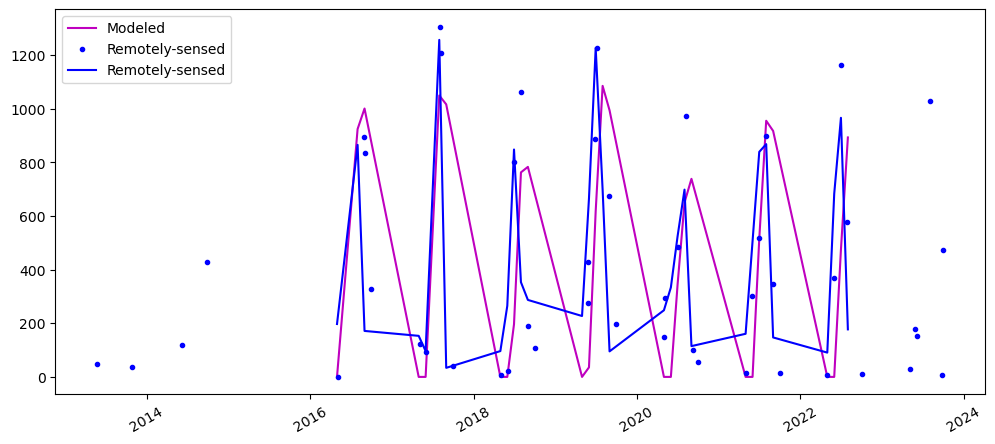

In [ ]:
rgi_id = 'RGI60-01.00032'
slas_site = slas_monthly_merged.loc[slas_monthly_merged['RGIId']==rgi_id]
slas_site['Date'] = pd.to_datetime(slas_site['Date'])

scs_fn = os.path.join(scm_path, 'study-sites', rgi_id, f'{rgi_id}_snow_cover_stats.csv')
scs = pd.read_csv(scs_fn)
scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
scs['Year'] = scs['datetime'].dt.year
scs['Month'] = scs['datetime'].dt.month
scs['Day'] = scs['datetime'].dt.day
# Filter data to within one week of the first of each month
scs_filtered = scs[(scs['Day'] >= 25) | (scs['Day'] <= 7)]
# Function to identify the row closest to the first of each month
Imonths = []
for year, month in scs_filtered[['Year', 'Month']].drop_duplicates().values:
    first_of_month = pd.Timestamp(year=year, month=month, day=1)
    # identify closest observation to this date
    scs_filtered.loc[:, 'diff'] = np.abs(scs_filtered.loc[:, 'datetime'] - first_of_month)
    Imonths.append(scs_filtered['diff'].idxmin())

scs_monthly = scs.iloc[Imonths]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(slas_site['Date'], slas_site['ELA_mod_m'], '-m', label='Modeled')
ax.plot(scs_monthly['datetime'], scs_monthly['ELA_from_AAR_m'] - min_obs_sla.loc[min_obs_sla['RGIId']==rgi_id, 'SLA_min_m'].values[0], 
        '.b', label='Remotely-sensed')
ax.plot(slas_site['Date'], slas_site['ELA_obs_m'], '-b', label='Remotely-sensed')
ax.legend(loc='best')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()


### Annual ELAs

In [20]:
elas_annual_merged = obs_elas_annual[['RGIId', 'Year', 'ELA_from_AAR_m']].merge(mod_elas_annual[['RGIId', 'Year', 'ELA_m']],
                                                                                on=['RGIId', 'Year'])
elas_annual_merged

,RGIId,Year,ELA_from_AAR_m,ELA_m
0,RGI60-01.00032,2016,2266.444200,2431.285897
1,RGI60-01.00032,2016,2266.444200,2431.285897
2,RGI60-01.00032,2016,1598.217317,2431.285897
3,RGI60-01.00032,2016,1572.440675,2431.285897
4,RGI60-01.00032,2016,2266.444200,2431.285897
...,...,...,...,...
307038,RGI60-01.26738,2017,2048.840000,2451.036835
307039,RGI60-01.26738,2017,2048.840000,2451.036835
307040,RGI60-01.26738,2017,2048.840000,2451.036835
307041,RGI60-01.26738,2017,2048.840000,2451.036835


Merged annual ELAs loaded.


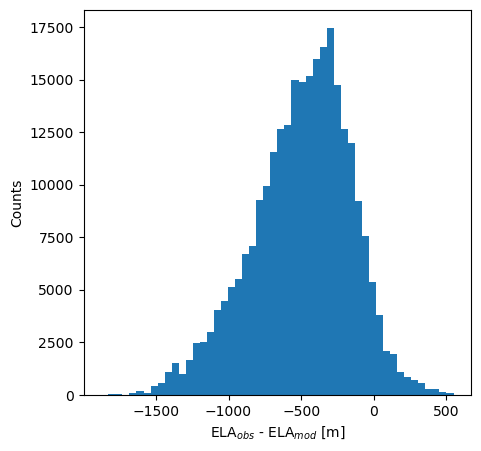


Difference stats:
Mean diff = -496.0387641508589 m
Std. diff = 339.8783245011836 m
Median diff = -462.44605203864455 m
MAD diff = 222.12216881013796 m


In [21]:
# Define output file name
elas_annual_merged_fn = os.path.join(scm_path, 'analysis', 'ELAs_annual_mod_obs_merged.csv')
if not os.path.exists(elas_annual_merged_fn):

    # Merge modeled and remotely-sensed modeled ELAs
    elas_annual_merged = obs_elas_annual[['RGIId', 'Year', 'ELA_from_AAR_m']].merge(mod_elas_annual[['RGIId', 'Year', 'ELA_m']],
                                                                                    on=['RGIId', 'Year'])
    
    # Rename columns
    elas_annual_merged.rename(columns={'ELA_from_AAR_m': 'ELA_obs_m', 'ELA_m': 'ELA_mod_m'}, inplace=True)
    
    # Remove 2023 values (no modeled data in 2023)
    elas_annual_merged = elas_annual_merged.loc[elas_annual_merged['Year'] < 2023]
        
    # Calculate difference
    elas_annual_merged['ELA_obs-mod_m'] = elas_annual_merged['ELA_obs_m'] - elas_annual_merged['ELA_mod_m']

    # Save results
    elas_annual_merged.to_csv(elas_annual_merged_fn, index=False)
    print('Merged annual ELAs saved to file:', elas_annual_merged_fn)

else:
    elas_annual_merged = pd.read_csv(elas_annual_merged_fn)
    print('Merged annual ELAs loaded.')
    
# Plot
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(elas_annual_merged['ELA_obs-mod_m'], bins=50)
ax.set_xlabel('ELA$_{obs}$ - ELA$_{mod}$ [m]')
ax.set_ylabel('Counts')
plt.show()


print('\nDifference stats:')
print(f'Mean diff = {np.nanmean((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'Std. diff = {np.nanstd((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'Median diff = {np.nanmedian((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'MAD diff = {MAD((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values, nan_policy="omit")} m')

In [22]:
for rgi_id in slas_monthly_merged['RGIId'].drop_duplicates().values:
    min_sla_obs = min_obs_sla.loc[min_obs_sla['RGIId']==rgi_id, 'SLA_min_m'].values[0]
    min_sla_mod = mod_slas_monthly.loc[mod_slas_monthly['RGIId']==rgi_id, 'ELA_m'].min()
    print(min_sla_obs, min_sla_mod)

1400.9528 1430.3176916919936
1107.1047 1132.145782027062
-425.24872 751.8920349531918
895.12897 871.4042198083625
54.785244 861.4544448511369
1061.1791 1078.836703599367
760.663 776.003020417092
1162.07 1171.753210164969
822.6225 838.0108491427911
981.76526 1011.9032346215544
663.93176 749.1683993794242
886.0784 926.567816348412
110.69 33.97097960286262
102.07627593774907 113.49084005974694
105.15131 115.84580619348148
758.71857 619.2478643286393
22.944504 96.92344515517226
-2.9348683 25.952379977698666
114.391266 265.3216843504463
547.7713 631.5635561351363
558.0 645.5536485048135
488.22617 586.6962872948217
1314.0 1371.4355235280957
345.4525 362.4575927288783
209.26251 275.8778968618877
507.6372 572.0553527459142
536.48444 579.5796210436274
417.40955 519.7067934437649
563.8656 605.4810218494141
228.55928 271.2076742887893
731.43677 538.0877925087293
452.22638 503.0198885886246
575.8379 599.8501933820717
575.001 598.9796878802347
165.56068 267.4252599147698
257.01892 330.679316005892
